# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [ ]:
!pip install pymongo

In [ ]:
!pip install pymongo[srv]

In [ ]:
!pip install dnspython

In [ ]:
!pip install tweepy

In [ ]:
!pip install twitter

## Import Python libraries

In [1]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [3]:
client = MongoClient(mongod_connect)
db = client.gp10 # use or create a database named demo
tweet_collection = db.lab10 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['covid19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [10]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

1327001371787337734
1327001371950915589
1327001373595078664
1327001373867732992
1327001375239249928
1327001376069652481
1327001377105616897
1327001376958910465
1327001377323802625
1327001378405961729
1327001379592867841
1327001379605508112
1327001379542589440
1327001380238880770
1327001380771520513
1327001381052571648
1327001381597798403
1327001382315036672
1327001382143074310
1327001382700847109
1327001383757881344
1327001385016172544
1327001385318055938
1327001386429640705
1327001387230769152
1327001387402731522
1327001386920386566
1327001388254195715
1327001388283465728
1327001388950450184
1327001389369856005
1327001389269200926
1327001390640750592
1327001391014010881
1327001392347828232
1327001392393969666
1327001392523800576
1327001393803055105
1327001394042327040
1327001394201702400
1327001394281320451
1327001395619385345
1327001396026150917
1327001396852342785
1327001397112541185
1327001397724901387
1327001397821259776
1327001398488264710
1327001398718828544
1327001398651875329


KeyboardInterrupt: 

## Use the REST API to Collect Tweets

Authorize the REST API 

In [11]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [12]:
count = 100 #number of returned tweets, default and max is 100
#geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [13]:
search_results = rest_api.search.tweets( count=count,q=q) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

TwitterHTTPError: Twitter sent status 429 for URL: 1.1/search/tweets.json using parameters: (count=100&oauth_consumer_key=R5MkumwEgUVoKBV5kRpTVFO6r&oauth_nonce=10838591273850655475&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1605216804&oauth_token=60388598-IidTtKJpbscMuepdlu3Lk9yaD3ReRNYPRe42Ylr26&oauth_version=1.0&q=covid19&oauth_signature=Kcmr9E7JEZcphIwsW8h%2FdD5XW1c%3D)
details: {'errors': [{'message': 'Rate limit exceeded', 'code': 88}]}

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [10]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                         max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Oct 28 20:39:14 +0000 2020'
'Wed Oct 28 20:39:13 +0000 2020'
'Wed Oct 28 20:39:13 +0000 2020'
'Wed Oct 28 20:39:13 +0000 2020'
'Wed Oct 28 20:39:13 +0000 2020'
'Wed Oct 28 20:39:13 +0000 2020'
'Wed Oct 28 20:39:13 +0000 2020'
'Wed Oct 28 20:39:12 +0000 2020'
'Wed Oct 28 20:39:12 +0000 2020'
'Wed Oct 28 20:39:12 +0000 2020'
'Wed Oct 28 20:39:12 +0000 2020'
'Wed Oct 28 20:39:12 +0000 2020'
'Wed Oct 28 20:39:12 +0000 2020'
'Wed Oct 28 20:39:11 +0000 2020'
'Wed Oct 28 20:39:11 +0000 2020'
'Wed Oct 28 20:39:11 +0000 2020'
'Wed Oct 28 20:39:11 +0000 2020'
'Wed Oct 28 20:39:11 +0000 2020'
'Wed Oct 28 20:39:10 +0000 2020'
'Wed Oct 28 20:39:10 +0000 2020'
'Wed Oct 28 20:39:10 +0000 2020'
'Wed Oct 28 20:39:10 +0000 2020'
'Wed Oct 28 20:39:10 +0000 2020'
'Wed Oct 28 20:39:09 +0000 2020'
'Wed Oct 28 20:39:09 +0000 2020'
'Wed Oct 28 20:39:09 +0000 2020'
'Wed Oct 28 20:39:09 +0000 2020'
'Wed Oct 28 20:39:09 +0000 2020'
'Wed Oct 28 20:39:09 +0000 2020'
'Wed Oct 28 20:39:08 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:38:30 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:29 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:28 +0000 2020'
'Wed Oct 28 20:38:27 +0000 2020'
'Wed Oct 28 20:38:27 +0000 2020'
'Wed Oct 28 20:38:27 +0000 2020'
'Wed Oct 28 20:38:27 +0000 2020'
'Wed Oct 28 20:38:26 +0000 2020'
'Wed Oct 28 20:38:26 +0000 2020'
'Wed Oct 28 20:38:26 +0000 2020'
'Wed Oct 28 20:38:26 +0000 2020'
'Wed Oct 28 20:38:25 +0000 2020'
'Wed Oct 28 20:38:25 +0000 2020'
'Wed Oct 28 20:38:25 +0000 2020'
'Wed Oct 28 20:38:25 +0000 2020'
'Wed Oct 28 20:38:25 +0000 2020'
'Wed Oct 28 20:38:24 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:37:14 +0000 2020'
'Wed Oct 28 20:37:14 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:13 +0000 2020'
'Wed Oct 28 20:37:12 +0000 2020'
'Wed Oct 28 20:37:12 +0000 2020'
'Wed Oct 28 20:37:12 +0000 2020'
'Wed Oct 28 20:37:12 +0000 2020'
'Wed Oct 28 20:37:12 +0000 2020'
'Wed Oct 28 20:37:12 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:11 +0000 2020'
'Wed Oct 28 20:37:10 +0000 2020'
'Wed Oct 28 20:37:10 +0000 2020'
'Wed Oct 28 20:37:10 +0000 2020'
'Wed Oct 28 20:37:10 +0000 2020'
'Wed Oct 28 20:37:10 +0000 2020'
'Wed Oct 28 20:37:09 +0000 2020'
'Wed Oct 28 20:37:09 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:36:37 +0000 2020'
'Wed Oct 28 20:36:37 +0000 2020'
'Wed Oct 28 20:36:36 +0000 2020'
'Wed Oct 28 20:36:36 +0000 2020'
'Wed Oct 28 20:36:36 +0000 2020'
'Wed Oct 28 20:36:36 +0000 2020'
'Wed Oct 28 20:36:36 +0000 2020'
'Wed Oct 28 20:36:36 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:35 +0000 2020'
'Wed Oct 28 20:36:34 +0000 2020'
'Wed Oct 28 20:36:34 +0000 2020'
'Wed Oct 28 20:36:34 +0000 2020'
'Wed Oct 28 20:36:34 +0000 2020'
'Wed Oct 28 20:36:33 +0000 2020'
'Wed Oct 28 20:36:33 +0000 2020'
'Wed Oct 28 20:36:33 +0000 2020'
'Wed Oct 28 20:36:33 +0000 2020'
'Wed Oct 28 20:36:33 +0000 2020'
'Wed Oct 28 20:36:32 +0000 2020'
'Wed Oct 28 20:36:32 +0000 2020'
'Wed Oct 28 20:36:32 +0000 2020'
'Wed Oct 28 20:36:32 +0000 2020'
'Wed Oct 28 20:36:32 +0000 2020'
'Wed Oct 28 20:36:32 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:35:55 +0000 2020'
'Wed Oct 28 20:35:55 +0000 2020'
'Wed Oct 28 20:35:54 +0000 2020'
'Wed Oct 28 20:35:54 +0000 2020'
'Wed Oct 28 20:35:54 +0000 2020'
'Wed Oct 28 20:35:54 +0000 2020'
'Wed Oct 28 20:35:54 +0000 2020'
'Wed Oct 28 20:35:54 +0000 2020'
'Wed Oct 28 20:35:53 +0000 2020'
'Wed Oct 28 20:35:53 +0000 2020'
'Wed Oct 28 20:35:53 +0000 2020'
'Wed Oct 28 20:35:53 +0000 2020'
'Wed Oct 28 20:35:53 +0000 2020'
'Wed Oct 28 20:35:52 +0000 2020'
'Wed Oct 28 20:35:52 +0000 2020'
'Wed Oct 28 20:35:52 +0000 2020'
'Wed Oct 28 20:35:52 +0000 2020'
'Wed Oct 28 20:35:52 +0000 2020'
'Wed Oct 28 20:35:52 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:51 +0000 2020'
'Wed Oct 28 20:35:50 +0000 2020'
'Wed Oct 28 20:35:50 +0000 2020'
'Wed Oct 28 20:35:50 +0000 2020'
'Wed Oct 28 20:35:50 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:35:12 +0000 2020'
'Wed Oct 28 20:35:12 +0000 2020'
'Wed Oct 28 20:35:12 +0000 2020'
'Wed Oct 28 20:35:12 +0000 2020'
'Wed Oct 28 20:35:11 +0000 2020'
'Wed Oct 28 20:35:11 +0000 2020'
'Wed Oct 28 20:35:11 +0000 2020'
'Wed Oct 28 20:35:11 +0000 2020'
'Wed Oct 28 20:35:11 +0000 2020'
'Wed Oct 28 20:35:11 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:10 +0000 2020'
'Wed Oct 28 20:35:09 +0000 2020'
'Wed Oct 28 20:35:09 +0000 2020'
'Wed Oct 28 20:35:09 +0000 2020'
'Wed Oct 28 20:35:09 +0000 2020'
'Wed Oct 28 20:35:09 +0000 2020'
'Wed Oct 28 20:35:09 +0000 2020'
'Wed Oct 28 20:35:08 +0000 2020'
'Wed Oct 28 20:35:08 +0000 2020'
'Wed Oct 28 20:35:08 +0000 2020'
'Wed Oct 28 20:35:08 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:34:31 +0000 2020'
'Wed Oct 28 20:34:31 +0000 2020'
'Wed Oct 28 20:34:31 +0000 2020'
'Wed Oct 28 20:34:31 +0000 2020'
'Wed Oct 28 20:34:31 +0000 2020'
'Wed Oct 28 20:34:30 +0000 2020'
'Wed Oct 28 20:34:30 +0000 2020'
'Wed Oct 28 20:34:30 +0000 2020'
'Wed Oct 28 20:34:30 +0000 2020'
'Wed Oct 28 20:34:30 +0000 2020'
'Wed Oct 28 20:34:30 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:29 +0000 2020'
'Wed Oct 28 20:34:28 +0000 2020'
'Wed Oct 28 20:34:28 +0000 2020'
'Wed Oct 28 20:34:28 +0000 2020'
'Wed Oct 28 20:34:28 +0000 2020'
'Wed Oct 28 20:34:28 +0000 2020'
'Wed Oct 28 20:34:28 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:33:56 +0000 2020'
'Wed Oct 28 20:33:56 +0000 2020'
'Wed Oct 28 20:33:55 +0000 2020'
'Wed Oct 28 20:33:55 +0000 2020'
'Wed Oct 28 20:33:55 +0000 2020'
'Wed Oct 28 20:33:55 +0000 2020'
'Wed Oct 28 20:33:55 +0000 2020'
'Wed Oct 28 20:33:55 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:54 +0000 2020'
'Wed Oct 28 20:33:53 +0000 2020'
'Wed Oct 28 20:33:53 +0000 2020'
'Wed Oct 28 20:33:52 +0000 2020'
'Wed Oct 28 20:33:52 +0000 2020'
'Wed Oct 28 20:33:52 +0000 2020'
'Wed Oct 28 20:33:52 +0000 2020'
'Wed Oct 28 20:33:52 +0000 2020'
'Wed Oct 28 20:33:51 +0000 2020'
'Wed Oct 28 20:33:51 +0000 2020'
'Wed Oct 28 20:33:51 +0000 2020'
'Wed Oct 28 20:33:50 +0000 2020'
'Wed Oct 28 20:33:50 +0000 2020'
'Wed Oct 28 20:33:50 +0000 2020'
'Wed Oct 28 20:33:50 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:33:15 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:14 +0000 2020'
'Wed Oct 28 20:33:13 +0000 2020'
'Wed Oct 28 20:33:13 +0000 2020'
'Wed Oct 28 20:33:13 +0000 2020'
'Wed Oct 28 20:33:13 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:12 +0000 2020'
'Wed Oct 28 20:33:11 +0000 2020'
'Wed Oct 28 20:33:11 +0000 2020'
'Wed Oct 28 20:33:11 +0000 2020'
'Wed Oct 28 20:33:11 +0000 2020'
'Wed Oct 28 20:33:11 +0000 2020'
'Wed Oct 28 20:33:11 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:36 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:35 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:34 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:33 +0000 2020'
'Wed Oct 28 20:32:32 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:31:53 +0000 2020'
'Wed Oct 28 20:31:53 +0000 2020'
'Wed Oct 28 20:31:53 +0000 2020'
'Wed Oct 28 20:31:53 +0000 2020'
'Wed Oct 28 20:31:53 +0000 2020'
'Wed Oct 28 20:31:53 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:52 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:51 +0000 2020'
'Wed Oct 28 20:31:50 +0000 2020'
'Wed Oct 28 20:31:50 +0000 2020'
'Wed Oct 28 20:31:50 +0000 2020'
'Wed Oct 28 20:31:50 +0000 2020'
'Wed Oct 28 20:31:50 +0000 2020'
'Wed Oct 28 20:31:49 +0000 2020'
'Wed Oct 28 20:31:49 +0000 2020'
'Wed Oct 28 20:31:49 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:31:15 +0000 2020'
'Wed Oct 28 20:31:15 +0000 2020'
'Wed Oct 28 20:31:15 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:14 +0000 2020'
'Wed Oct 28 20:31:13 +0000 2020'
'Wed Oct 28 20:31:13 +0000 2020'
'Wed Oct 28 20:31:13 +0000 2020'
'Wed Oct 28 20:31:13 +0000 2020'
'Wed Oct 28 20:31:13 +0000 2020'
'Wed Oct 28 20:31:13 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:12 +0000 2020'
'Wed Oct 28 20:31:11 +0000 2020'
'Wed Oct 28 20:31:11 +0000 2020'
'Wed Oct 28 20:31:10 +0000 2020'
'Wed Oct 28 20:31:10 +0000 2020'
'Wed Oct 28 20:31:10 +0000 2020'
'Wed Oct 2

'Wed Oct 28 20:30:37 +0000 2020'
'Wed Oct 28 20:30:37 +0000 2020'
'Wed Oct 28 20:30:37 +0000 2020'
'Wed Oct 28 20:30:37 +0000 2020'
'Wed Oct 28 20:30:37 +0000 2020'
'Wed Oct 28 20:30:37 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:36 +0000 2020'
'Wed Oct 28 20:30:35 +0000 2020'
'Wed Oct 28 20:30:35 +0000 2020'
'Wed Oct 28 20:30:35 +0000 2020'
'Wed Oct 28 20:30:35 +0000 2020'
'Wed Oct 28 20:30:35 +0000 2020'
'Wed Oct 28 20:30:35 +0000 2020'
'Wed Oct 28 20:30:34 +0000 2020'
'Wed Oct 28 20:30:34 +0000 2020'
'Wed Oct 28 20:30:34 +0000 2020'
'Wed Oct 28 20:30:34 +0000 2020'
'Wed Oct 28 20:30:34 +0000 2020'
'Wed Oct 28 20:30:34 +0000 2020'
'Wed Oct 28 20:30:33 +0000 2020'
'Wed Oct 28 20:30:33 +0000 2020'
'Wed Oct 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [11]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

3863
3484


Create a text index and print the Tweets containing specific keywords. 

In [12]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [13]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pprint to display tweets

In [14]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Tolu Taiwo
text: RT @kilonpop: If COVID19 didn't delay elections in Edo and Ondo states, you have no excuse.
----
name: Mabi juliet
text: RT @kilonpop: If COVID19 didn't delay elections in Edo and Ondo states, you have no excuse.
----
name: Peggy Mueller
text: RT @franlondon: @RepAndyBiggsAZ How do you expect to get re-elected if you have no interest in keeping us safe from the spread of #COVID19…
----
name: Naveen [Lighthouse]
text: When you understand science and when you don’t...&amp; then it is election time. #WhoisRight #AnythingLeft  #StaySafe… https://t.co/PG8R8Sz5DA
----
name: CLIVISORY🔊
text: RT @NuNaveen: When you understand science and when you don’t...&amp; then it is election time. #WhoisRight #AnythingLeft  #StaySafe #CheerUp #C…
----
name: Oyomwan O. Jio
text: RT @NuNaveen: When you understand science and when you don’t...&amp; then it is election time. #WhoisRight #AnythingLeft  #StaySafe #CheerUp #C…
----
name: Deborah Lasyone
text: RT @KarensTreasure: The A

In [15]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pandas to display tweets

In [16]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweeted_status,is_quote_status,quoted_status_id,quoted_status_id_str,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive
0,5f99d775b684f1bc1f93da78,Wed Oct 28 20:31:24 +0000 2020,1321550152306429952,1321550152306429952,RT @kilonpop: If COVID19 didn't delay election...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",None,...,{'created_at': 'Tue Oct 27 06:36:32 +0000 2020...,True,1.320836e+18,1320835728264339462,3353,0,False,False,en,NaN
1,5f99d766b684f1bc1f93d514,Wed Oct 28 20:34:49 +0000 2020,1321551014491787270,1321551014491787270,RT @kilonpop: If COVID19 didn't delay election...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,{'created_at': 'Tue Oct 27 06:36:32 +0000 2020...,True,1.320836e+18,1320835728264339462,3353,0,False,False,en,NaN
2,5f99d772b684f1bc1f93d977,Wed Oct 28 20:32:02 +0000 2020,1321550312021393409,1321550312021393409,RT @franlondon: @RepAndyBiggsAZ How do you exp...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,{'created_at': 'Wed Oct 21 19:18:59 +0000 2020...,False,NaN,NaN,3,0,False,False,en,NaN
3,5f99d778b684f1bc1f93dbb4,Wed Oct 28 20:30:38 +0000 2020,1321549958735142912,1321549958735142912,When you understand science and when you don’t...,True,"{'hashtags': [{'text': 'WhoisRight', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",None,...,NaN,False,NaN,NaN,2,1,False,False,en,False
4,5f99d771b684f1bc1f93d8e6,Wed Oct 28 20:32:26 +0000 2020,1321550414622371845,1321550414622371845,RT @NuNaveen: When you understand science and ...,False,"{'hashtags': [{'text': 'WhoisRight', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,{'created_at': 'Wed Oct 28 20:30:38 +0000 2020...,False,NaN,NaN,2,0,False,False,en,NaN
5,5f99d764b684f1bc1f93d482,Wed Oct 28 20:35:10 +0000 2020,1321551101628502016,1321551101628502016,RT @NuNaveen: When you understand science and ...,False,"{'hashtags': [{'text': 'WhoisRight', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,{'created_at': 'Wed Oct 28 20:30:38 +0000 2020...,False,NaN,NaN,2,0,False,False,en,NaN
6,5f99d773b684f1bc1f93da08,Wed Oct 28 20:31:40 +0000 2020,1321550221508284416,1321550221508284416,RT @KarensTreasure: The American ppl used as p...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,{'created_at': 'Wed Oct 28 08:41:25 +0000 2020...,False,NaN,NaN,7,0,False,False,en,NaN
7,5f99d772b684f1bc1f93d95a,Wed Oct 28 20:32:07 +0000 2020,1321550335031259137,1321550335031259137,Living monuments of Trump’s failures arrive in...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,NaN,False,NaN,NaN,1,0,False,False,en,False
8,5f99d771b684f1bc1f93d91e,Wed Oct 28 20:32:17 +0000 2020,1321550376164904962,1321550376164904962,Rallies and election campaigns a font of lies ...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,NaN,False,NaN,NaN,0,0,False,False,en,False
9,5f99d761b684f1bc1f93d357,Wed Oct 28 20:35:57 +0000 2020,1321551298899173376,1321551298899173376,"RT @umcjustice: During this election season, w...",False,"{'hashtags': 

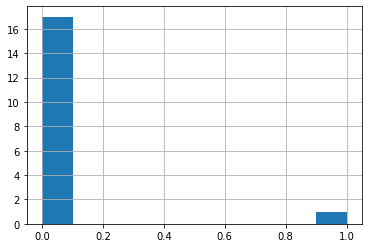

In [17]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count